In [125]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread, imresize
import cv2

from ipywidgets import widgets, interactive, FloatSlider, IntSlider, IntRangeSlider, FloatRangeSlider, RadioButtons

%matplotlib inline

In [199]:
def abs_sobel(img_ch, orient='x', sobel_kernel=3):
    if orient == 'x':
        axis = (1, 0)
    elif orient == 'y':
        axis = (0, 1)
    else:
        raise ValueError('orient has to be "x" or "y" not "%s"' % orient)

    sobel = cv2.Sobel(img_ch, -1, *axis, ksize=sobel_kernel)
    abs_s = np.absolute(sobel)

    return abs_s


def gradient_magnitude(sobel_x, sobel_y):
    abs_grad_mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    return abs_grad_mag.astype(np.uint16)


def gradient_direction(sobel_x, sobel_y):
    with np.errstate(divide='ignore', invalid='ignore'):
        abs_grad_dir = np.absolute(np.arctan(sobel_y / sobel_x))
        max_val = np.nanmax(abs_grad_dir)
        abs_grad_dir[np.isnan(abs_grad_dir)] = max_val

    return abs_grad_dir.astype(np.float32)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

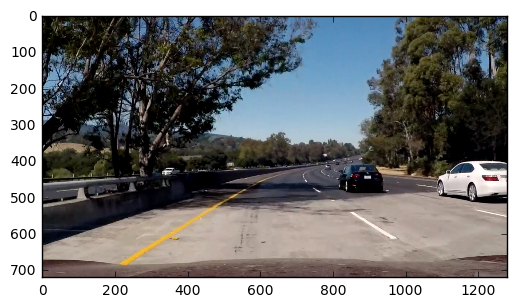

In [68]:
img = imread('test_images/test5.jpg')
img = imresize(img, (720//1, 1280//1, 3))
plt.imshow(img, cmap='gray')

# Magnitude and Direction of Gradient

In [159]:
def mag_dir_thresh(i, magth, dirth, r, g, b, y, u, v, h, l, s):
    img = images[i]
    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    yuv = 255-yuv
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    nb_ch = sum([r, g, b, y, u, v, h, l, s])
    ch = np.zeros((*img.shape[:-1], nb_ch))
    i = 0
    if r:
        ch[:,:,i] = img[:,:,0]
        i += 1
    if g:
        ch[:,:,i] = img[:,:,1]
        i += 1
    if b:
        ch[:,:,i] = img[:,:,2]
        i += 1
        
    if y:
        ch[:,:,i] = yuv[:,:,0]
        i += 1
    if u:
        ch[:,:,i] = yuv[:,:,1]
        i += 1
    if v:
        ch[:,:,i] = yuv[:,:,2]
        i += 1
        
    if h:
        ch[:,:,i] = hls[:,:,0]
        i += 1
    if l:
        ch[:,:,i] = hls[:,:,1]
        i += 1
    if s:
        ch[:,:,i] = hls[:,:,2]
        i += 1
        
    
    gray = np.mean(ch, 2)
    x = abs_sobel_thresh(gray, orient='x')
    y = abs_sobel_thresh(gray, orient='y')
    mag = gradient_magnitude_thresh(x, y)
    dir = gradient_direction_thresh(x, y)
    #mag = mag/mag.max()

    binary = np.zeros(mag.shape)
    binary[(mag >= magth[0]) & (mag <= magth[1]) & (dir >= dirth[0]) & (dir <= dirth[1])] = 1
    plt.imshow(binary, cmap='gray')

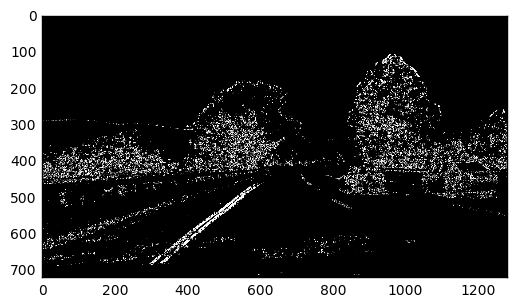

In [163]:
images = []
for i in range(1, 18):
    images.append(imread('test_images/test%s.jpg' % i))
    
interactive(mag_dir_thresh,
            i=IntSlider(min=1, max=len(images)-1, step=1, value=1),  
            magth=IntRangeSlider(min=0, max=255, step=1,value=[0, 255]),
            dirth=FloatRangeSlider(min=0, max=np.pi / 2, step=0.01,value=[0, np.pi / 2]),
            r=False, g=False, b=False,
            y=False, u=True, v=True,
            h=False, l=False, s=True)

# Sobel Threshold

In [151]:
def sobel_thresh(i, threshx, threshy, kernel, noise_red, r, g, b, y, u, v, h, l, s):
    img = images[i]
    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    yuv = 255-yuv
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    nb_ch = sum([r, g, b, y, u, v, h, l, s])
    ch = np.zeros((*img.shape[:-1], nb_ch))
    i = 0
    if r:
        ch[:,:,i] = img[:,:,0]
        i += 1
    if g:
        ch[:,:,i] = img[:,:,1]
        i += 1
    if b:
        ch[:,:,i] = img[:,:,2]
        i += 1
        
    if y:
        ch[:,:,i] = yuv[:,:,0]
        i += 1
    if u:
        ch[:,:,i] = yuv[:,:,1]
        i += 1
    if v:
        ch[:,:,i] = yuv[:,:,2]
        i += 1
        
    if h:
        ch[:,:,i] = hls[:,:,0]
        i += 1
    if l:
        ch[:,:,i] = hls[:,:,1]
        i += 1
    if s:
        ch[:,:,i] = hls[:,:,2]
        i += 1
        
    
    gray = np.mean(ch, 2).astype(np.float32)/255
    mask = np.zeros(img.shape)
    
    sx = abs_sobel_thresh(gray, orient='x', sobel_kernel=kernel)
    sy = abs_sobel_thresh(gray, orient='y', sobel_kernel=kernel)

    
    mask[(sx >= threshx[0]) & (sx <= threshx[1]) & (sy >= threshy[0]) & (sy <= threshy[1])] = 1
    mask = binary_noise_reduction(mask, noise_red)
    
    plt.imshow(mask, cmap='gray')

In [156]:
def binary_noise_reduction(img, thresh):
    k = np.array([[1, 1, 1],
                  [0, 0, 0],
                  [1, 1, 1]])
    nb_neighbours = cv2.filter2D(img, ddepth=-1, kernel=k)
    img[nb_neighbours < thresh] = 0
    return img

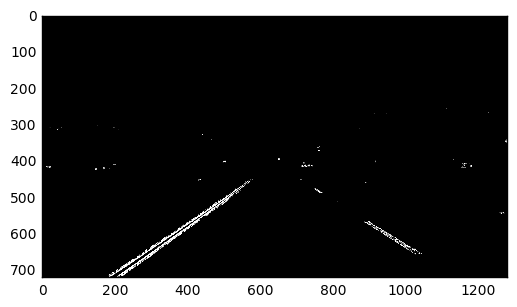

In [152]:
images = []
for i in range(1, 18):
    images.append(imread('test_images/test%s.jpg' % i))
    
interactive(sobel_thresh,
            i = IntSlider(min=1, max=len(images)-1, step=1, value=1),
            threshx=FloatRangeSlider(min=0, max=1, step=0.01,value=[0.1, 0.6]),
            threshy=FloatRangeSlider(min=0, max=1, step=0.01,value=[0.1, 0.6]),
            kernel=IntSlider(min=1, max=21, step=2, value=3),
            noise_red=IntSlider(min=0, max=8, step=1, value=0),
            r=False, g=False, b=False,
            y=False, u=True, v=True,
            h=False, l=False, s=True)

# Extract yellow

In [201]:
def extract_yellow(i, intv1, intv2, intv3, blur):
    img = gaussian_blur(images[i], blur)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, (intv1[0], intv2[0], intv3[0]), (intv1[1], intv2[1], intv3[1]))

    plt.imshow(mask, cmap='gray')

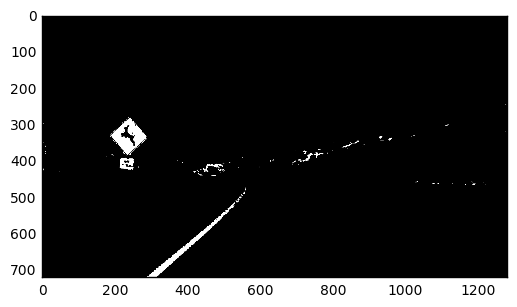

In [206]:
images = []
for i in range(1, 20):
    images.append(imread('test_images/test%s.jpg' % i))
    
interactive(extract_yellow,
            i=IntSlider(min=1, max=len(images)-1, step=1, value=1),
            intv1=IntRangeSlider(min=0, max=255, step=1,value=[20, 40]),
            intv2=IntRangeSlider(min=0, max=255, step=1,value=[50, 255]),
            intv3=IntRangeSlider(min=0, max=255, step=1,value=[150, 255]),
            blur=IntSlider(min=1, max=37, step=2, value=1))

# Extract white

In [112]:
def extract_white(i, intv1, intv2, intv3):
    #lab = cv2.cvtColor(images[i], cv2.COLOR_RGB2LAB)
    mask = cv2.inRange(images[i], (intv1[0], intv2[0], intv3[0]), (intv1[1], intv2[1], intv3[1]))

    plt.imshow(mask, cmap='gray')

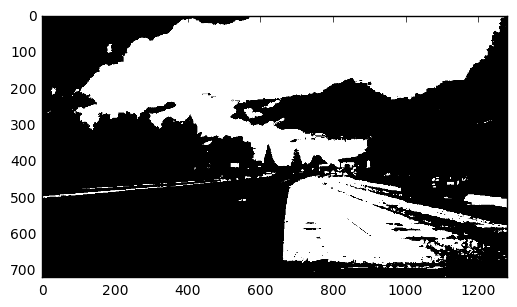

In [113]:
images = []
for i in range(1, 18):
    images.append(imread('test_images/test%s.jpg' % i))
    
interactive(extract_white,
            i=IntSlider(min=1, max=len(images)-1, step=1, value=1),
            intv1=IntRangeSlider(min=0, max=255, step=1,value=[0, 25]),
            intv2=IntRangeSlider(min=0, max=255, step=1,value=[100, 255]),
            intv3=IntRangeSlider(min=0, max=255, step=1,value=[150, 255]))

# Perspective transform

In [164]:
class PerspectiveTransformer:
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.M_inv = cv2.getPerspectiveTransform(dst, src)

    def transform(self, img):
        return cv2.warpPerspective(img, self.M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    def inverse_transform(self, img):
        return cv2.warpPerspective(img, self.M_inv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

In [184]:
def persp_trans(i, offset, y, llx, ulx, urx, lrx):
    
    SRC = np.float32([
    (llx, y[1]),
    (ulx, y[0]),
    (urx, y[0]),
    (lrx, y[1])])

    DST = np.float32([
        (SRC[0][0] + offset, SRC[0][1]),
        (SRC[0][0] + offset, 0),
        (SRC[-1][0] - offset, 0),
        (SRC[-1][0] - offset, SRC[0][1])])

    pt = PerspectiveTransformer(SRC, DST)
    img = images[i]
    plt.imshow(pt.transform(img))

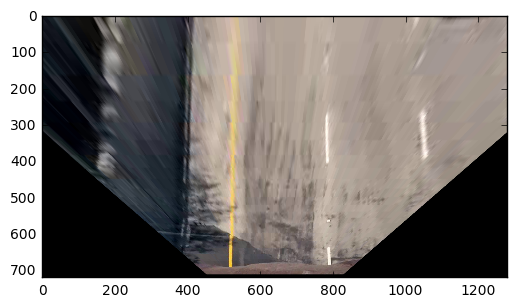

In [208]:
images = []
for i in range(1, 19):
    images.append(imread('test_images/test%s.jpg' % i))
    
images.append(imread('test_images/ref_img.jpg'))
images.append(imread('test_images/ground_plane.jpg'))
interactive(persp_trans,
            i=IntSlider(min=1, max=len(images)-1, step=1, value=1),
            y=IntRangeSlider(min=0, max=720, step=1,value=[466, 703]),
            offset=IntSlider(min=0, max=1280/2, step=1,value=350),
            llx=IntSlider(min=0, max=1280, step=1,value=132),
            ulx=IntSlider(min=0, max=1280, step=1,value=540),
            urx=IntSlider(min=0, max=1280, step=1,value=740),
            lrx=IntSlider(min=0, max=1280, step=1,value=1147))

In [285]:
def transform_lines(i, llx, lly, ulx, uly, lrx, lry, urx, ury, depth, offset):
    ly = [lly, uly]
    lx = [llx, ulx]
    lz = np.polyfit(ly, lx, 1)
    lp = np.poly1d(lz)
    
    ry = [lry, ury]
    rx = [lrx, urx]  
    rz = np.polyfit(ry, rx, 1)
    rp = np.poly1d(rz)
    
    fig, axis = plt.subplots(1,2, figsize=(12, 3))
    
    lxp = np.linspace(400, 700, 100)
    _ = axis[0].plot(lx, ly, '.', lp(lxp), lxp, '-')
    
    rxp = np.linspace(400, 700, 100)
    _ = axis[0].plot(rx, ry, '.', rp(rxp), rxp, '-')

    img = images[i]
    _ = axis[0].imshow(img)
    
    lanker = int(lp(depth))
    ranker = int(rp(depth))
    _ = axis[0].plot([lanker, ranker],[depth, depth],  '.')
    
    
    SRC = np.float32([
    (llx, lly),
    (lanker, depth),
    (ranker, depth),
    (lrx, lry)])

    DST = np.float32([
        (SRC[0][0] + offset, 720),
        (SRC[0][0] + offset, 0),
        (SRC[-1][0] - offset, 0),
        (SRC[-1][0] - offset, 720)])

    pt = PerspectiveTransformer(SRC, DST)
    _ = axis[1].imshow(pt.transform(img))
    
    axis[0].axis('off')
    axis[1].axis('off')
    
    axis[0].text(0, -50, str((lanker, depth)))
    axis[0].text(1000, -50, str((ranker, depth)))
    
    #print('left anker:', (lanker, depth), 'right anker:', (ranker, depth))

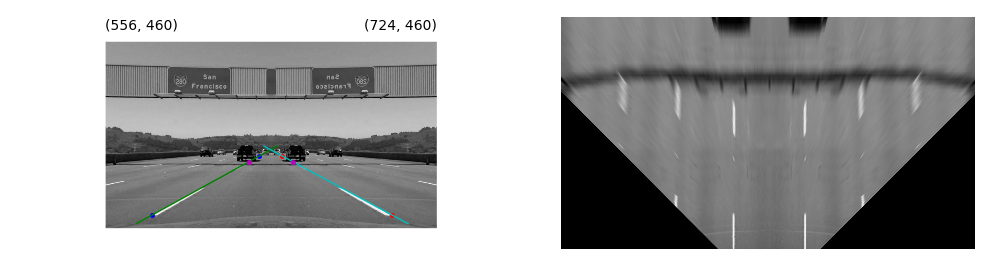

In [287]:
images = []
for i in range(1, 19):
    images.append(imread('test_images/test%s.jpg' % i))
    
images.append(imread('test_images/ref_img.jpg'))
images.append(imread('test_images/ground_plane.jpg'))

interactive(transform_lines,
            i=IntSlider(min=1, max=len(images)-1, step=1, value=18),
            llx=IntSlider(min=0, max=1280, step=1,value=180),
            lly=IntSlider(min=400, max=720, step=1,value=667),
            ulx=IntSlider(min=0, max=1280, step=1,value=596),
            uly=IntSlider(min=400, max=720, step=1,value=438),
            lrx=IntSlider(min=0, max=1280, step=1,value=1110),
            lry=IntSlider(min=400, max=720, step=1,value=667),
            urx=IntSlider(min=0, max=1280, step=1,value=684),
            ury=IntSlider(min=400, max=720, step=1,value=438),
            offset=IntSlider(min=0, max=1280/2, step=1,value=350),
            depth=IntSlider(min=400, max=720, step=1,value=460))